<a href="https://colab.research.google.com/github/cairoegito/Cliente-Churn-da-Magalu/blob/main/Ensemble_Cliente_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1- Objetivo do projeto e análise exploratória**

Identificar possíveis clientes de churn, ou seja, que costumavam comprar com frequência na loja e de maneira repentina cessaram as mesmas. Vamos usar algumas técnicas de Machine Learning para projetarmos o melhor modelo e depois avaliarmos qual será a mais promissora e eficaz.

In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.1 MB/s 


In [ ]:
#Importando bibliotecas para análise exploratória dos dados
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px 
import shap
from datetime import date
 
#Biblioteca para processamento de dados
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN


#Bibliotecas para Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from IPython.display import display, SVG
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler



In [ ]:
#Importando a base de dados
df = pd.read_csv("/content/drive/MyDrive/Desafio Magalu/client.test.csv", sep=',', encoding='utf-8')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Observando as primeiras linhas de nosso dataset
df.head()

,client_id,birthdate,state,gender,is_churn
0,cx06840,1982-12-03,st15,cg1,False
1,cx01931,1979-05-09,st15,cg1,False
2,cx35431,1965-05-09,st15,cg1,False
3,cx36233,1954-03-15,st15,cg2,False
4,cx13540,1965-06-19,st15,cg1,False


In [ ]:
#Observando o tamanho de nosso dataset
df.shape

(7764, 5)

In [ ]:
#Observando as variáveis
df.describe()

,client_id,birthdate,state,gender,is_churn
count,7764,7764,7764,7764,7764
unique,7764,6252,25,2,2
top,cx06840,1990-01-01,st15,cg1,False
freq,1,18,2723,4241,6368


In [ ]:
#Verificando possíveis dados missings
df.isnull().sum()

client_id    0
birthdate    0
state        0
gender       0
is_churn     0
dtype: int64

In [ ]:
# análise univariada da data de nascimento
fig = px.histogram(df, x="birthdate") 
fig.show()

In [ ]:
# Convertendo data de nascimento para idade

df['birthdate'] = pd.to_datetime(df['birthdate'], format = '%Y-%m-%d')

def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

df['age'] = df['birthdate'].apply(calculate_age)

In [ ]:
# Criação de grupos para tentar gerar insights mais específicos sobre o cliente ser churn
age_groups = []

for age in df.age:
  if age <= 18:
    age_groups.append(1)
  elif 19 <= age <= 30:
    age_groups.append(2)
  elif 31 <= age <= 45:
    age_groups.append(3)
  elif 46 <= age <= 60:
    age_groups.append(4)
  elif age >= 61:
    age_groups.append(5)

df['age_groups'] = age_groups

In [ ]:
df.head()

,client_id,birthdate,state,gender,is_churn,age,age_groups
0,cx06840,1982-12-03,st15,cg1,False,39,3
1,cx01931,1979-05-09,st15,cg1,False,43,3
2,cx35431,1965-05-09,st15,cg1,False,57,4
3,cx36233,1954-03-15,st15,cg2,False,68,5
4,cx13540,1965-06-19,st15,cg1,False,57,4


In [ ]:
# análise univariada dos estados
fig = px.histogram(df, x="state") 
fig.show()

In [ ]:
# análise univariada do gênero
fig = px.histogram(df, x="gender")
fig.show()

Percebemos alguns outliers nas variáveis, mas que optarei por manter por enquanto pois não transformei ainda as variáveis em numéricas. A única variável que, como esperado, apresenta desbalanceamento é a "is_churn", que é nossa variável de  futura predição e por isso terá isso mantido por enquanto

**Análise de dados e modelos**

In [ ]:
#Utilizando o OneLabelEncoder
aplication_label_encoder = LabelEncoder()

In [ ]:
#Transformando as variáveis desejadas
label_encoder_cliente_id = LabelEncoder()
label_encoder_birth_date = LabelEncoder()
label_encoder_state = LabelEncoder()
label_encoder_gender = LabelEncoder()
label_encoder_is_churn = LabelEncoder()

In [ ]:
# Separando nossas colunas do dataset para a transformação das variáveis para quantitativas
df.iloc[:, 0] = label_encoder_cliente_id.fit_transform(df.iloc[:, 0])
df.iloc[:, 1] = label_encoder_birth_date.fit_transform(df.iloc[:, 1])
df.iloc[:,2] = label_encoder_state.fit_transform(df.iloc[:,2])
df.iloc[:,3] = label_encoder_gender.fit_transform(df.iloc[:,3])
df.iloc[:,4] = label_encoder_is_churn.fit_transform(df.iloc[:,4])

In [ ]:
#Checando a transformação
df.head()

,client_id,birthdate,state,gender,is_churn,age,age_groups
0,1419,3824,13,0,0,39,3
1,412,3191,13,0,0,43,3
2,7058,1416,13,0,0,57,4
3,7234,461,13,1,0,68,5
4,2680,1433,13,0,0,57,4


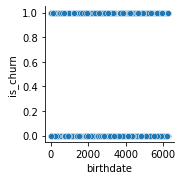

In [ ]:
#Agora vamos fazer algumas análises bivariadas. Iniciando pela relação entre birthdate e is_churn
sns.pairplot(y_vars='is_churn', x_vars=['birthdate'], data=df)



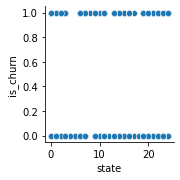

In [ ]:
#Entre os estados dos compradores e se é churn
sns.pairplot(y_vars='is_churn', x_vars=['state'], data=df)


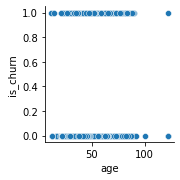

In [ ]:
#Entre as idades e se é churn
sns.pairplot(y_vars='is_churn', x_vars=['age'], data=df)


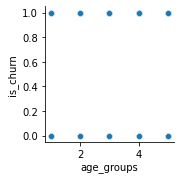

In [ ]:
sns.pairplot(y_vars='is_churn', x_vars=['age_groups'], data=df)


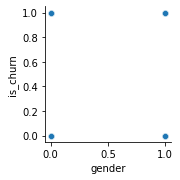

In [ ]:
# Entre os gêneros e se é churn 
sns.pairplot(y_vars='is_churn', x_vars=['gender'], data=df)


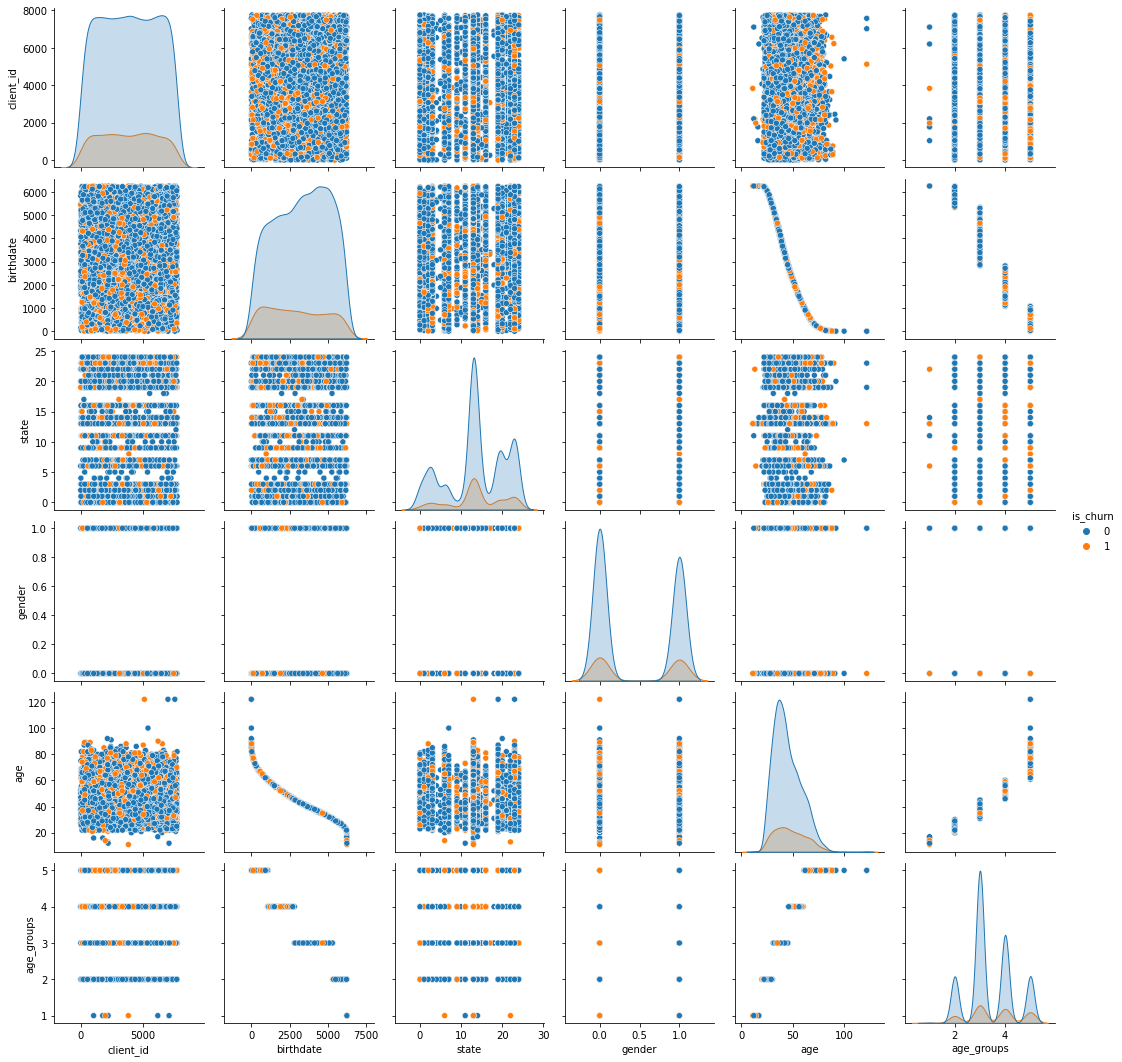

In [ ]:
# Verificando com mais detalhes os gráficos simultâneamente 
sns.pairplot(df, hue = "is_churn")

In [ ]:
#Por fim, vamos observar as correlações do dataframe com nossa variável de maior interesse
df.corr()["is_churn"].sort_values(ascending= False)


is_churn      1.000000
age           0.083856
age_groups    0.071106
gender        0.020581
state         0.009816
client_id    -0.009328
birthdate    -0.075810
Name: is_churn, dtype: float64

Da análise bivariada não retemos muitas informações importantes. Entretanto, estudando a nossa variável que iremos prever de maneira isolada e suas correlações com as outras, conseguimos retirar pontos mais preciosos do comportamento da mesma, de tal forma que o gênero do cliente será uma relação importante em nosso modelo

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



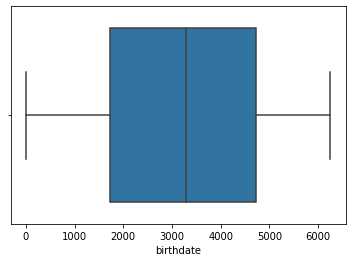

In [ ]:
#Visualizando o boxplot da variável birthdate
sns.boxplot(df["birthdate"]);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



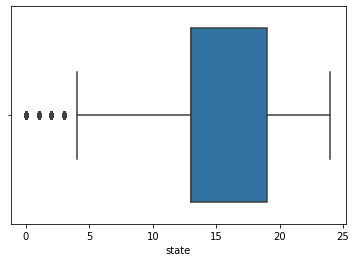

In [ ]:
#Visualizando o boxplot da variável state
sns.boxplot(df["state"]);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



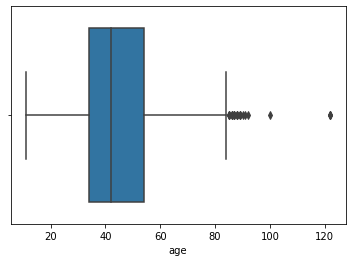

In [ ]:
#BoxPlot da variável idade
sns.boxplot(df["age"]);

In [ ]:
# Calculando as distâncias interquartis e exclusão dos outliers da variável state
q25_age = df.age.quantile(0.25)
q75_age = df.age.quantile(0.75)
iqr_age = q75_age-q25_age
# Excluindo registros para além de 1,5*IQR
df2 = df[(df.age>=q25_age-1.5*iqr_age) & (df.age<=q25_age+1.5*iqr_age)]
# Estatísticas finais da base
print('Tamanho da base antes da exclusão de outliers: {}'.format(len(df)))
print('Tamanho da base após a exclusão de outliers: {}'.format(len(df2)))
print('Perda percentual de registros: {:.1f}%'.format((len(df)-len(df2))/len(df)*100))

Tamanho da base antes da exclusão de outliers: 7764
Tamanho da base após a exclusão de outliers: 6974
Perda percentual de registros: 10.2%


In [ ]:
#Checando dataset
df2.head()

,client_id,birthdate,state,gender,is_churn,age,age_groups
0,1419,3824,13,0,0,39,3
1,412,3191,13,0,0,43,3
2,7058,1416,13,0,0,57,4
4,2680,1433,13,0,0,57,4
5,4155,736,13,0,0,64,5


Tratamos os outliers apenas da variável state, aja visto que a "Gender" tem somente duas possibilidades, assim como a "is_churn" e que a variável birthdate no BoxPlot não possui outliers evidentes

**3 - Modelo Random Forest com 100 árvores**

In [ ]:
#Separando para a predição
x = df2.iloc[: , 1:4]
y = df2["is_churn"]

In [ ]:
#Separando para treino e teste
x_train, x_test, y_train, y_test = train_test_split(x , y , test_size=0.3 , random_state=0)

In [ ]:
#Indicando modelo
modelo = RandomForestClassifier(n_estimators=100, criterion="entropy",random_state=0)

In [ ]:
#Treinando o modelo
modelo.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=0)

In [ ]:
#Balanceando as classes
smt = SMOTE()

In [ ]:
#Agora vamos balancear a variável is_churn
x, y = smt.fit_resample(x, y)


In [ ]:
# Contagem do is_churn após smote
yi= y.astype(int)
np.bincount(yi)

array([5793, 5793])

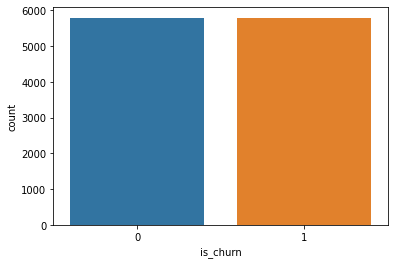

In [ ]:
#Verificando o rebalanceamento
ax = sns.countplot(x=yi)


In [ ]:
#Fazendo a previsão
previsoes = modelo.predict(x_test)
previsoes

array([1, 0, 0, ..., 1, 0, 0])

In [ ]:
# Analisando as métricas desse modelo de previsão e sua confiabilidade 
accuracy_score(y_test, previsoes)

0.7190635451505016

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



0.7190635451505016

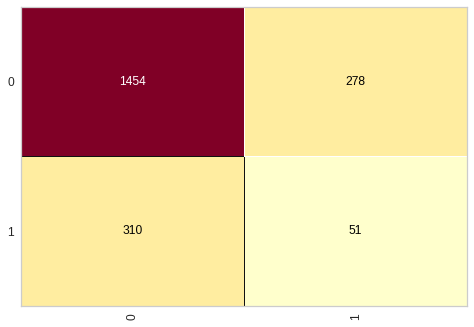

In [ ]:
from yellowbrick.classifier import ConfusionMatrix
matriz = ConfusionMatrix(modelo)
matriz.fit(x_train, y_train)
matriz.score(x_test, y_test)

Aqui optei pelo balanceamento por OverSampling, pois quis manter minhas informações já confirmadas, então optei por preencher a variável is_churn com "False". Entretanto, para isso primeiro treinei o modelo com o dataset real e desbalanceado, só após isso fiz o balanceamento em um novo DataFrame. A matriz de confusão também nos indica os parâmetros de certos e errados. O modelo Random Forest já é um ensemble do tipo Bagging, afinal ele utiliza vários nós com diversas decisões, no nosso caso 100. Optei por pegar um número razoável de árvores, afinal um número muito pequeno de nós poderia ter dificuldade em prever funções mais complexas

**4 -Modelo por SVM**

In [ ]:
df_new = SVC(kernel="poly", random_state=1, C=3.0)
df_new.fit(x_train, y_train)

SVC(C=3.0, kernel='poly', random_state=1)

In [ ]:
# Findando o modelo
previsoes = df_new.predict(x_test)
previsoes

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
#Fazendoo leve comparativo
y_test

3713    1
5280    1
3658    0
5425    0
656     1
       ..
6254    0
3992    0
2737    0
4579    0
3068    0
Name: is_churn, Length: 2093, dtype: int64

In [ ]:
# Analisando as métricas desse modelo de previsão e sua confiabilidade 
print("Classification metrics: \n" , classification_report(y_test, previsoes))
print("Acurácia: \n", accuracy_score(y_test, previsoes))

Classification metrics: 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91      1732
           1       0.00      0.00      0.00       361

    accuracy                           0.83      2093
   macro avg       0.41      0.50      0.45      2093
weighted avg       0.68      0.83      0.75      2093

Acurácia: 
 0.8275203057811753


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



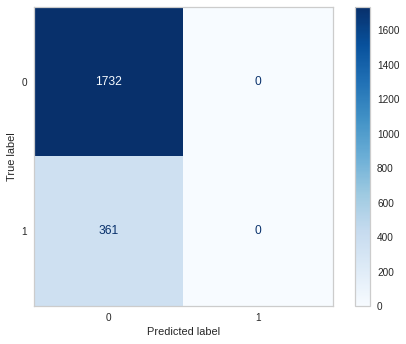

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, (previsoes >= 0.5).astype(int), cmap="Blues")
plt.grid(False)

Dessa vez, utilizamos um modelo SVM, que tenta criar planos em uma distribuição de dados de tal forma que uma função consiga representar o comportamento da variável. Nesse caso optamos por uma polinomial, que verifica e checa mais pontos que uma linear, por exemplo. Por fim, verificamos a acurácia e também sua matriz de confusão.

**5 - XGBoost**

In [ ]:
modelo2 = XGBClassifier()


In [ ]:
#Treinando o modelo
modelo2 = modelo2.fit(x_train, y_train)
modelo2

XGBClassifier()

In [ ]:
#Passando novos dados
y_predict = modelo2.predict(x_test)

In [ ]:
# Criando gabarito para analisar os resultados
gabarito = pd.DataFrame({"Gabarito" : y_test, "Previsoes da máquina": y_predict})
gabarito

,Gabarito,Previsoes da máquina
3713,1,0
5280,1,0
3658,0,0
5425,0,0
656,1,0
...,...,...
6254,0,0
3992,0,0
2737,0,0
4579,0,0


In [ ]:
# Analisando as métricas desse modelo de previsão e sua confiabilidade 
print("Classification metrics: \n" , classification_report(y_test, y_predict))
print("Acurácia: \n", accuracy_score(y_test, y_predict))

Classification metrics: 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91      1732
           1       0.00      0.00      0.00       361

    accuracy                           0.83      2093
   macro avg       0.41      0.50      0.45      2093
weighted avg       0.68      0.83      0.75      2093

Acurácia: 
 0.8270425226946966


0.8270425226946966

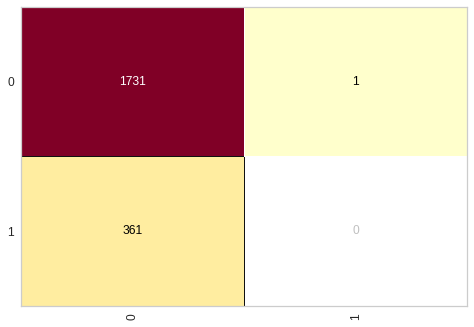

In [ ]:
from yellowbrick.classifier import ConfusionMatrix
matriz = ConfusionMatrix(modelo2)
matriz.fit(x_train, y_train)
matriz.score(x_test, y_test)

Dessa vez utilizamos um modelo XGBoost. O *recall* nos indica o quanto nosso modelo está identificando os casos positivos corretamente. Também fizemos uma matriz de confusão para melhor visualização de resultados, onde temos 381 falsos positivos

**Analisando modelos  com o SHAP**

### -Random Forest
### -SVM
### -XGBoost

In [ ]:
shap.initjs()

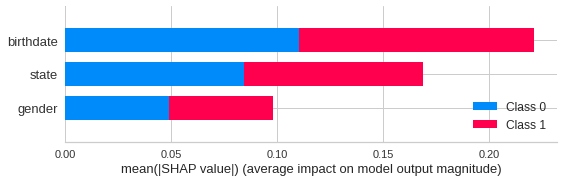

In [ ]:
#Explanando as influências das variáveis na predição (Random Forest)
explainer = shap.TreeExplainer(modelo)
shap_values = explainer.shap_values(x)
shap.summary_plot(shap_values, x)

In [ ]:
#Gráfico de força individual  (Random Forest)
shap.initjs()
columIndex= 2
shap.force_plot(explainer.expected_value[1], shap_values[1][columIndex,:], x.iloc[columIndex,:], link="logit")

A interpretação desse SHAP nos leva a crer que as variáveis data de nascimento e o estado (em específico o do grupo 13), nos influenciou mais a um cliente não ser churn. Enquanto a variável de gênero "sexo" e "idade" nos influencia mais em o cliente ser churn.